In [3]:
# Name: example_basic
# Authors: Stephan Meighen-Berger, Kruteesh Desai
# A basic example how to use the package

In [4]:
# imports
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np
import matplotlib.pyplot as plt
from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
import pickle

In [5]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$',r'$\nu_{e}$',r'$\nu_{\tau}$']

In [6]:
# Some example settings
#config['atmospheric showers']['interaction model'] = 'SIBYLL2.3c'
#config['atmospheric showers']['theta angles'] = np.linspace(0., 90., 91)
#config['atmospheric showers']['particles of interest']=['nue']
config['general']['detector'] = 'POne'
config["general"]["year"] = 7

In [7]:
pdm = PDM()

  0%|          | 0/20 [00:00<?, ?it/s]/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:344: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:345: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd
100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


In [8]:
# Grids
mass_grid = config['simulation parameters']['mass grid']
sv_grid = config['simulation parameters']['sv grid']
# The limit calculation


In [9]:
dphi_4=np.loadtxt(open("../data/m_1e4.csv"), delimiter = ",")
dphi_4[dphi_4[:,0].sort()]
dphi_ice=np.loadtxt(open("../data/icecube.csv"), delimiter = ",")
dphi_ice[dphi_ice[:,0].sort()]

array([[[2.12522998e+02, 1.63541848e-04],
        [3.75355026e+02, 1.17293567e-04],
        [6.29536175e+02, 4.82400307e-05],
        [1.29846584e+03, 2.68117327e-05],
        [2.54321174e+03, 1.27334869e-05],
        [5.08126850e+03, 5.00379406e-06],
        [1.02741133e+04, 1.64695632e-06],
        [2.01231674e+04, 6.33333228e-07],
        [4.15055504e+04, 3.04185979e-07],
        [8.12939394e+04, 1.45312927e-07],
        [1.64454709e+05, 5.65882534e-08],
        [2.78806881e+05, 4.47804058e-08],
        [4.21663736e+05, 3.16824398e-08],
        [7.56379773e+05, 2.36346234e-08],
        [1.97223492e+06, 1.29547786e-08]]])

In [10]:
dphi=UnivariateSpline(dphi_4[:,0],dphi_4[:,1],k=1,s=0)
dphi_ic=UnivariateSpline(dphi_ice[:,0],dphi_ice[:,1],k=1,s=0)

/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:344: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:345: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd


(100.0, 11000.0)

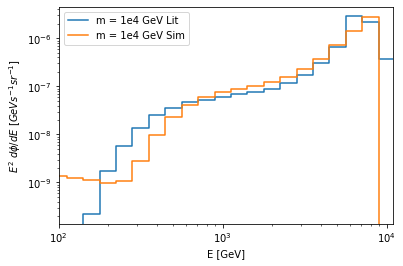

In [11]:
mass_id = 10
sv_id = -1
#plt.step(pdm._shower_sim.egrid,pdm._limit_calc._signal_counts[mass_grid[mass_id]][sv_grid[sv_id]],label=r'$m_{x}$ = %.1e GeV, <$\sigma\nu$> = %.1e' %(mass_grid[mass_id], sv_grid[sv_id]))
plt.step(pdm._shower_sim._egrid, dphi(pdm._shower_sim._egrid), label='m = 1e4 GeV Lit')
plt.step(pdm._shower_sim.egrid, pdm._dm_nu.extra_galactic_flux(pdm._shower_sim.egrid, 1e4, 1e-24) * pdm._shower_sim.egrid**2.,
         label='m = 1e4 GeV Sim')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$E^2$ $d\phi/dE$ $[GeV s^{-1} sr^{-1}]$')
plt.xlabel('E [GeV]')
plt.legend()
plt.xlim(1e2, 1.1e4)

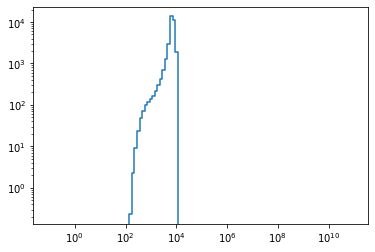

In [12]:
# Litterature differential fluxes converting to counts 

down_angles = []
horizon_angles = []
lit_down= []
lit_hor = []

A_55 = np.loadtxt( "../data/A_55.csv", delimiter=",")
A_15 = np.loadtxt( "../data/A_15.csv", delimiter=",")
A_51 = np.loadtxt( "../data/A_51.csv", delimiter=",")
A_55 = A_55[A_55[:, 0].argsort()]
A_15 = A_15[A_15[:, 0].argsort()]
A_51 = A_51[A_51[:, 0].argsort()]
A_55 = np.concatenate((np.array([[100, 0]]), A_55), axis=0)
A_15 = np.concatenate((np.array([[100, 0]]), A_15), axis=0)
A_51 = np.concatenate((np.array([[100, 0]]), A_51), axis=0)

_A_15 = UnivariateSpline(A_15[:, 0], A_15[:, 1] *
                                      1e4, k=1, s=0, ext=3)
_A_51 = UnivariateSpline(A_51[:, 0], A_51[:, 1] *
                                      1e4, k=1, s=0, ext=3)
_A_55 = UnivariateSpline(A_55[:, 0], A_55[:, 1] *
                                      1e4, k=1, s=0, ext=3)


_uptime=config["simulation parameters"]["uptime"]
for angle in config['atmospheric showers']['theta angles']:
            rad = np.deg2rad(np.abs(angle - 90.))

            # Downgoing
            if np.pi / 3 <= rad <= np.pi / 2:
                down_angles.append(rad)
                lit_down.append(
                    dphi(pdm._shower_sim.egrid) *  pdm._shower_sim._egrid**(-2) *_uptime *
                    pdm._shower_sim._ewidth * _A_15(pdm._shower_sim._egrid)
                )

# * pdm._shower_sim._egrid**(-2)
            # Horizon
            else:
                horizon_angles.append(rad)
                lit_hor.append(
                     dphi(pdm._shower_sim.egrid) * pdm._shower_sim._egrid**(-2) * _uptime *
                    pdm._shower_sim._ewidth *_A_55(pdm._shower_sim._egrid)
                )

# Converting to numpy arrays
lit_down = np.array(lit_down)
lit_hor = np.array(lit_hor)
down_angles = np.array(down_angles)
horizon_angles = np.array(horizon_angles)

# Integrating

_lit = np.zeros_like(pdm._shower_sim._egrid)


# Downgoing

sorted_ids = np.argsort(down_angles)
_lit += np.trapz(lit_down[sorted_ids],
                                x=down_angles[sorted_ids], axis=0)


# Horizon we assume it is mirrored

sorted_ids = np.argsort(horizon_angles)
_lit += 2. * np.trapz(lit_hor[sorted_ids],
                                     x=horizon_angles[sorted_ids], axis=0)

# Upgoing we assume the same flux for all
_lit += ((np.pi / 2 - np.pi / 3) *
           dphi(pdm._shower_sim.egrid)  * pdm._shower_sim._egrid**(-2) * _uptime *
                    pdm._shower_sim._ewidth * _A_51(pdm._shower_sim._egrid)
        )

plt.step(pdm._shower_sim._egrid,_lit)
plt.xscale('log')
plt.yscale('log')

In [13]:
# Plotting standards
std_size = 15.  # Size of the plot
fontsize = 25.  # Fontsize in the plot
lw=0.5  # Linewidth
h_length=0.5  # Handle length for the legends
export_dpi = 500  # Dpi for the image export

In [14]:
th_cl = np.loadtxt(open("../data/thermal_relic.csv"), delimiter = ",")
angle_grid = np.logspace(0,90,91)

In [15]:
signal_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/limits_signal_IceCube.pkl','rb'))


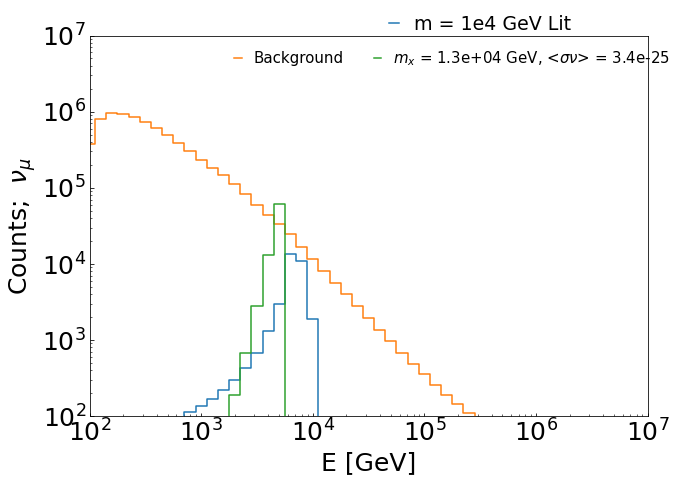

In [16]:
# plotting the Counts----
for j,i in enumerate(config['atmospheric showers']['particles of interest'][:1]):
    # Particle counts
    # ---------------------------------------------
    # Setup
    figure, ax1 = plt.subplots(1, 1, figsize=(10,7), sharey=True)
    # ---------------------------------------------
    # Plotting
    ax1.step(pdm._shower_sim._egrid,_lit ,label='m = 1e4 GeV Lit')
    #ax1.step(pdm._shower_sim._egrid, ,label='IceCube Background')
    ax1.step(pdm._shower_sim.egrid,
             pdm._limit_calc._bkgrd[i],
             label='Background')
    mass_id = 7
    sv_id = 5
    #ax1.step(pdm._shower_sim.egrid[-len(signal_ice[mass_id][sv_id]):],
    #         signal_ice[mass_id][sv_id] ,
    #         label=r'$m_{x}$ = %.1e GeV, <$\sigma\nu$> = %.1e' %(mass_grid[mass_id], sv_grid[sv_id]))
    ax1.step(pdm._shower_sim.egrid[-len(pdm.signal[mass_id][sv_id]):],
             pdm.signal[mass_id][sv_id],
             label=r'$m_{x}$ = %.1e GeV, <$\sigma\nu$> = %.1e' %(mass_grid[mass_id], sv_grid[sv_id]))
   # yy =pdm._signal._signal_calc(pdm._shower_sim._egrid,mass_grid[mass_id],sv_grid[sv_id],angle_grid)*(pdm._shower_sim.egrid)**2 
    #print(yy)
    # ax1.step(pdm._shower_sim.egrid,
    #         pdm._limit_calc._bkgrd[i] + pdm._signal._signal_calc(pdm._shower_sim._egrid,mass_grid[mass_id],sv_grid[sv_id],angle_grid),
    #         label='Total', color='k')
    # The correspondin CL value
 
   
    #mass_id = -1
    #sv_id = 1
    #ax1.step(pdm._shower_sim.egrid[-len(signal_ice[mass_id][sv_id]):],
     #        signal_ice[mass_id][sv_id],
      #       label=r'$m_{x}$ = %.1e GeV, <$\sigma\nu$> = %.1e' %(mass_grid[mass_id], sv_grid[sv_id]))
    # Corresponding CL value

   
    # ---------------------------------------------
    # Axis options
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel(r"E [GeV]", fontsize=fontsize)
    ax1.set_ylabel("Counts;  " + name[j], fontsize=fontsize)
    ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    
    if j==0:
        ax1.set_ylim(1e2, 1e7)
        ax1.set_xlim(1e2, 1e7)
    elif j==1:
        ax1.set_ylim(1e0, 1e5)
        ax1.set_xlim(1e2, 1e7)
    #elif j==2:
    #    ax1.set_ylim(1e0, 1e4)
    #    ax1.set_xlim(1e2, 1e7)
    #
    # ---------------------------------------------
    # Legend
    h, l = ax1.get_legend_handles_labels()
    
    lgd1 = ax1.legend([h[0]], [l[0]], loc=9, bbox_to_anchor=(0.7, +1.1),
                      ncol=2, fontsize=fontsize-6, handlelength=h_length,
                      fancybox=True, frameon=False)
    lgd2 = ax1.legend(h[1:], l[1:], loc=9, bbox_to_anchor=(0.65, +1.0),
                      ncol=2, fontsize=fontsize-10, handlelength=h_length,
                      fancybox=True, frameon=False)
    ax1.add_artist(lgd1)
    # ---------------------------------------------
    # Showing the image
    plt.show()
    # ---------------------------------------------
    # Storing the image
    figure.savefig(PICS + "Flux_Example_"+i+".png",
                   bbox_inches='tight', dpi=export_dpi)

In [17]:
test_chi2 = {}
for i in config["pone"]["specific particle scaling"].keys():
    test_chi2[i] = np.array([[
        (pdm._signal._signal_calc(pdm._shower_sim._egrid,mass_grid[mass_id],sv_grid[sv_id],angle_grid)[pdm._limit_calc._t_d:] /
        pdm._limit_calc._bkgrd[i][pdm._limit_calc._t_d:] for mass_id in range(0, len(mass_grid)))
        ] for sv_id in range(0, len(sv_grid))])

In [18]:
# Loading comparison data
cl_lit = np.loadtxt('../data/CL_PONE.csv', delimiter=",")
cl_lit = (cl_lit[cl_lit[:, 0].argsort()])

In [19]:
pdm.results['numu'][0]

array([0.96924471, 0.94859799, 0.98077934, 0.95182225, 0.98294765,
       0.96375794, 0.9883665 , 0.9761296 , 0.95376235, 0.98555522,
       0.97515743, 0.99291151, 0.98948816, 0.98713499, 0.99669872,
       0.99627197, 0.99912106, 0.99910147, 0.99979878, 0.99980626])

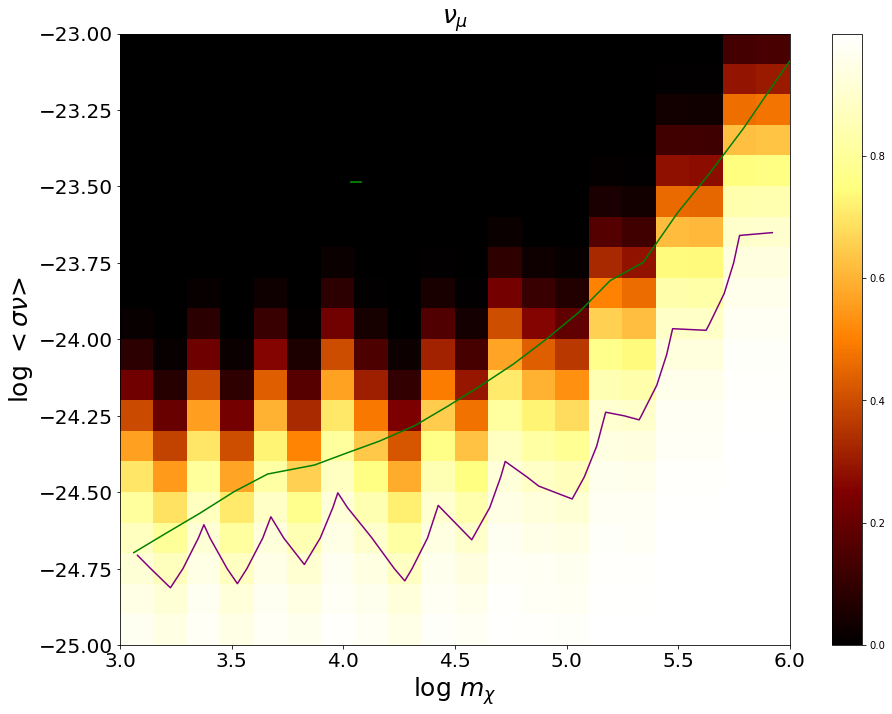

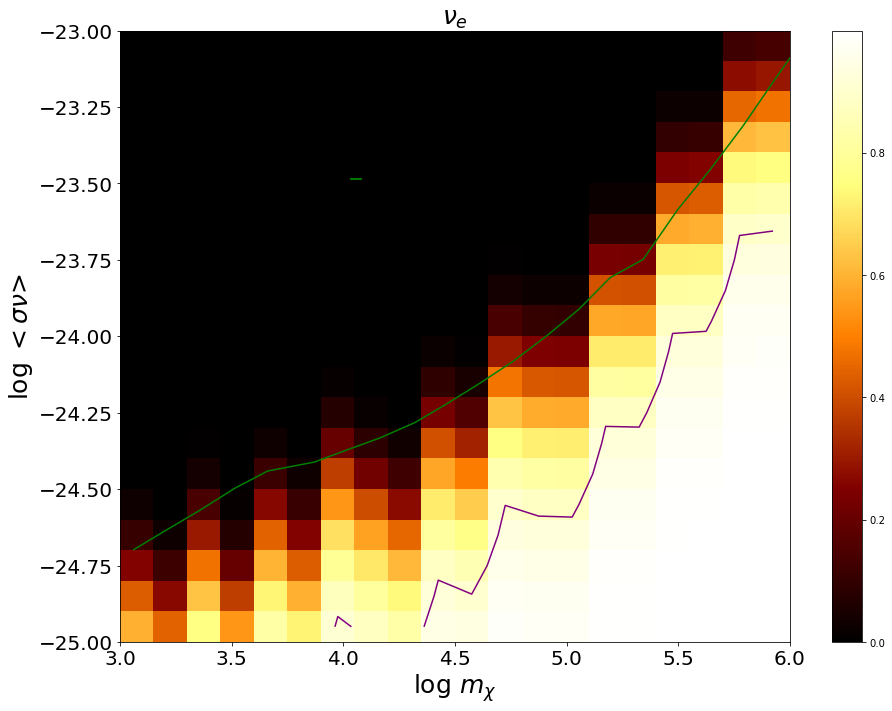

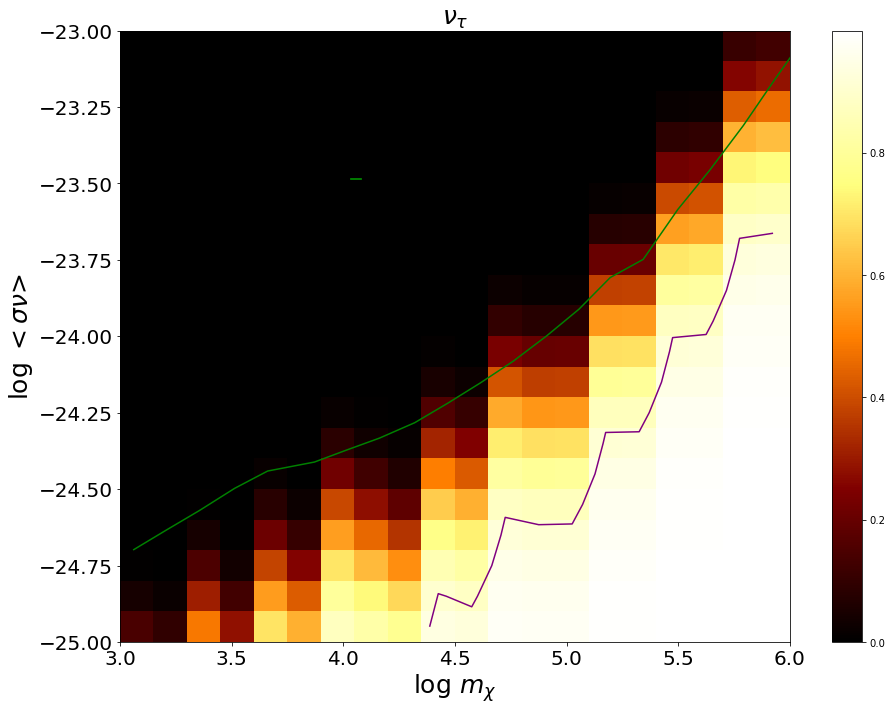

In [20]:
for j,i in enumerate(config["pone"]["specific particle scaling"].keys()):
    # Limits
    # ---------------------------------------------
    # Setup

    figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
    # ---------------------------------------------
    # Plotting
    plt.title(name[j],fontsize=fontsize)
    ax1.contour( pdm.results[i], levels = [0.9], colors='purple',
                origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                        min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    pos = ax1.imshow( pdm.results[i], extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                              min(np.log10(sv_grid)), max(np.log10(sv_grid))),
                     origin='lower', aspect='auto',cmap=plt.cm.afmhot)
    figure.colorbar(pos, ax=ax1)
    ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L')
    # ---------------------------------------------
    # Axis options
    ax1.set_xscale("linear")
    ax1.set_yscale("linear")
    ax1.set_xlabel(r"$\log$ $m_{\chi}$", fontsize=fontsize)
    ax1.set_ylabel(r"$\log$ $<\sigma \nu$>", fontsize=fontsize)
    ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5)
    ax1.set_xlim(min(np.log10(mass_grid)), max(np.log10(mass_grid)))
    ax1.set_ylim(min(np.log10(sv_grid)), max(np.log10(sv_grid)))
    # ---------------------------------------------
    # Legend
    # plt.legend(fontsize=fontsize)
    h, l = ax1.get_legend_handles_labels()
    lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.5, +0.8),
                     ncol=2, fontsize=fontsize-5, handlelength=h_length,
                     fancybox=True, frameon=False)
    ax1.add_artist(lgd1)
    # ---------------------------------------------
    # Showing the image
    plt.show()
    # ---------------------------------------------
    # Storing the image
    figure.savefig(PICS + "Limits_Example_"+i+".png",
                   bbox_inches='tight', dpi=export_dpi)

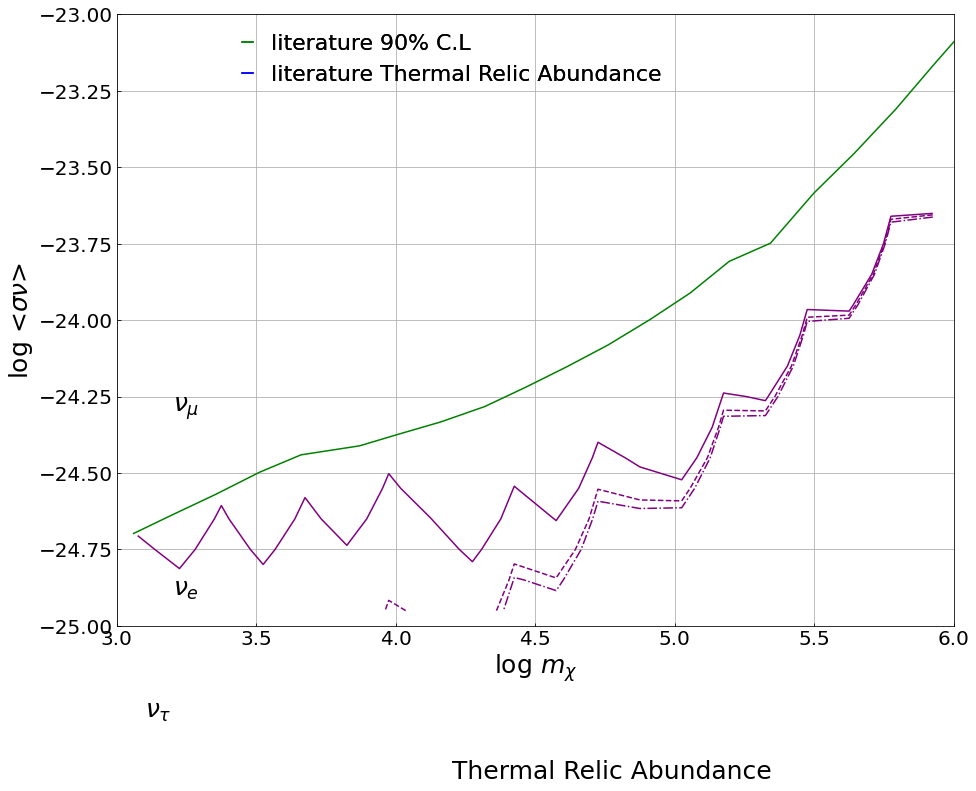

In [21]:
# All Limits-------------------------------------------
# Setup
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
ax1.contour(pdm.results["numu"], levels = [0.9], colors='purple', linestyles='-',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nue"], levels = [0.9], colors='purple', linestyles='--',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nutau"], levels = [0.9], colors='purple', linestyles='-.',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L')
ax1.plot(np.log10(th_cl[:, 0]), np.log10(th_cl[:, 1]), 'b', 
         label='literature Thermal Relic Abundance')
# ---------------------------------------------
# Axis options
ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.set_xlabel(r"log $m_{\chi}$", fontsize=fontsize)
ax1.set_ylabel(r"log <$\sigma\nu$>", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')
ax1.set_xlim(min(np.log10(mass_grid)), max(np.log10(mass_grid)))
ax1.set_ylim(min(np.log10(sv_grid)),-23.0)
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
ax1.text(3.2, -24.3, r"$\nu_\mu$", fontsize=fontsize)
ax1.text(3.2, -24.9, r"$\nu_e$", fontsize=fontsize)
ax1.text(3.1, -25.3, r"$\nu_\tau$", fontsize=fontsize)
ax1.text(4.2, -25.5, "Thermal Relic Abundance", fontsize=fontsize)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "All_Limits.png",
               bbox_inches='tight', dpi=export_dpi)